# **Descrição**

**Nome do aluno:** Matheus X. Melotti.

Este notebook apresenta a solução para o desafio "Ghouls, Goblins and Ghosts..." proposto pela Kaggle. Cujo o objetivo é identificar e classificar corretamente criaturas sobrenaturais que estão assombrando a Kaggle usando algoritmos de machine learning.

**Dados disponibilizados:**

**File descriptions:**
- train.csv - the training set
- test.csv - the test set
- sample_submission.csv - a sample submission file in the correct format

**Data fields:**
- id - id da criatura
- bone_length - comprimento médio do osso na criatura, normalizado entre 0 e 1
- rotting_flesh - porcentagem de carne podre na criatura
- hair_length - comprimento médio do cabelo, normalizado entre 0 e 1
- has_soul - porcentagem de alma na criatura
- color - cor dominante da criatura: 'white','black','clear','blue','green','blood'
- type - variável de destino: 'Ghost', 'Goblin', and 'Ghoul'

Link do desafio no kaggle: https://www.kaggle.com/competitions/ghouls-goblins-and-ghosts-boo/overview

In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [3]:
workdir = os.path.join(os.getcwd())

## Carregando os datasets

In [4]:
df_ssub = pd.read_csv(os.path.join(workdir, "Resources/sample_submission.csv"))
df_ssub.head()

,id,type
0,3,Ghost
1,6,Ghost
2,9,Ghost
3,10,Ghost
4,13,Ghost


In [5]:
df_train = pd.read_csv(os.path.join(workdir, "Resources/train.csv"))
df_train_aux = df_train.copy()
display(len(df_train))
df_train.head()

371

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
0,0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul
1,1,0.575560,0.425868,0.531401,0.439899,green,Goblin
2,2,0.467875,0.354330,0.811616,0.791225,black,Ghoul
3,4,0.776652,0.508723,0.636766,0.884464,black,Ghoul
4,5,0.566117,0.875862,0.418594,0.636438,green,Ghost


In [6]:
df_test = pd.read_csv(os.path.join(workdir, "Resources/test.csv"))
df_test_aux = df_test.copy()
display(len(df_test))
df_test.head()

529

,id,bone_length,rotting_flesh,hair_length,has_soul,color
0,3,0.471774,0.387937,0.706087,0.698537,black
1,6,0.427332,0.645024,0.565558,0.451462,white
2,9,0.549602,0.491931,0.660387,0.449809,black
3,10,0.638095,0.682867,0.471409,0.356924,white
4,13,0.361762,0.583997,0.377256,0.276364,black


In [7]:
total = len(df_test) + len(df_train)
print("Porcentagem da base alocada para treino: ", len(df_train)*100/total)
print("Porcentagem da base alocada para teste: ", len(df_test)*100/total)

Porcentagem da base alocada para treino:  41.22222222222222
Porcentagem da base alocada para teste:  58.77777777777778


## Descrevendo os dados

In [8]:
df_train.head(20)

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
0,0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul
1,1,0.575560,0.425868,0.531401,0.439899,green,Goblin
2,2,0.467875,0.354330,0.811616,0.791225,black,Ghoul
3,4,0.776652,0.508723,0.636766,0.884464,black,Ghoul
4,5,0.566117,0.875862,0.418594,0.636438,green,Ghost
5,7,0.405680,0.253277,0.441420,0.280324,green,Goblin
6,8,0.399331,0.568952,0.618391,0.467901,white,Goblin
7,11,0.516224,0.536429,0.612776,0.468048,clear,Ghoul
8,12,0.314295,0.671280,0.417267,0.227548,blue,Ghost
9,19,0.280942,0.701457,0.179633,0.141183,white,Ghost


In [9]:
df_train.columns

Index(['id', 'bone_length', 'rotting_flesh', 'hair_length', 'has_soul',
       'color', 'type'],
      dtype='object')

In [10]:
df_test.columns

Index(['id', 'bone_length', 'rotting_flesh', 'hair_length', 'has_soul',
       'color'],
      dtype='object')

In [11]:
for column in df_train.columns:
  if column not in df_test.columns:
    print("Coluna do treino não está na tabela de teste: ", column)

for column in df_test.columns:
  if column not in df_train.columns:
    print("Coluna do teste não está na tabela de treino: ", column)

Coluna do treino não está na tabela de teste:  type


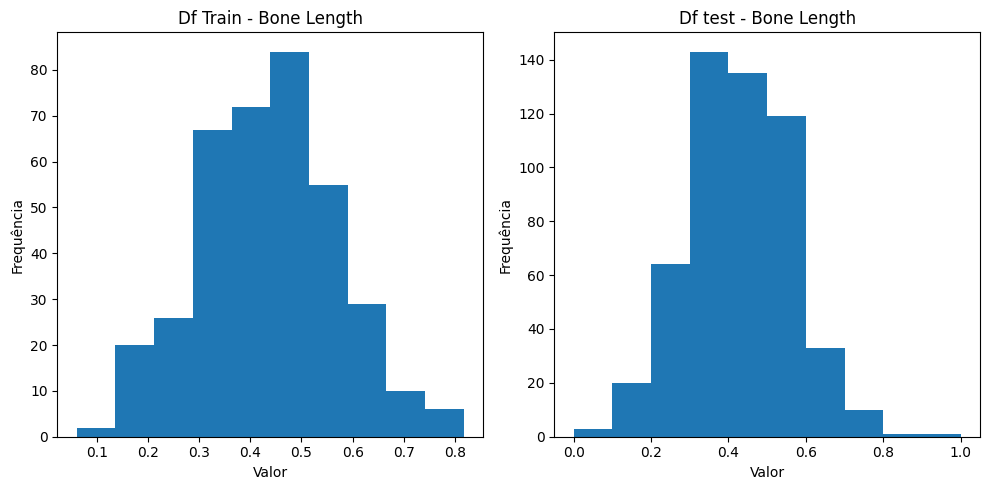

In [12]:
# Bone Length

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))


ax1.hist(df_train['bone_length'])
ax1.set_title('Df Train - Bone Length')
ax1.set_xlabel('Valor')
ax1.set_ylabel('Frequência')


ax2.hist(df_test['bone_length'])
ax2.set_title('Df test - Bone Length')
ax2.set_xlabel('Valor')
ax2.set_ylabel('Frequência')


plt.tight_layout()
plt.show()

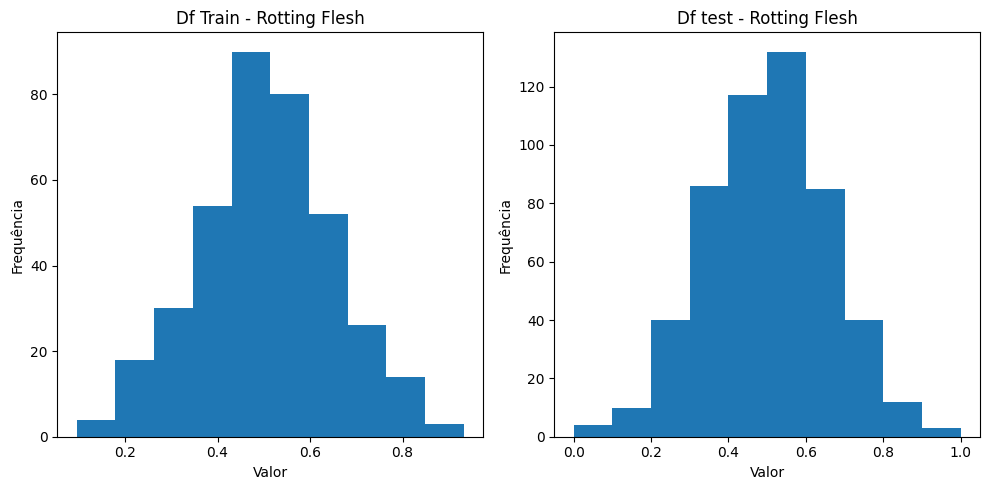

In [13]:
# Rotting Flesh

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))


ax1.hist(df_train['rotting_flesh'])
ax1.set_title('Df Train - Rotting Flesh')
ax1.set_xlabel('Valor')
ax1.set_ylabel('Frequência')


ax2.hist(df_test['rotting_flesh'])
ax2.set_title('Df test - Rotting Flesh')
ax2.set_xlabel('Valor')
ax2.set_ylabel('Frequência')


plt.tight_layout()
plt.show()

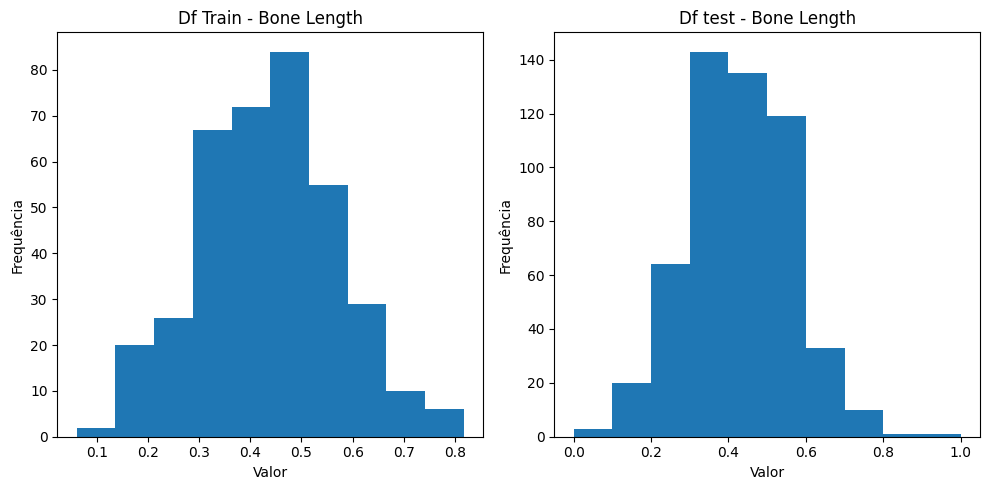

In [14]:
# Bone Length

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))


ax1.hist(df_train['bone_length'])
ax1.set_title('Df Train - Bone Length')
ax1.set_xlabel('Valor')
ax1.set_ylabel('Frequência')


ax2.hist(df_test['bone_length'])
ax2.set_title('Df test - Bone Length')
ax2.set_xlabel('Valor')
ax2.set_ylabel('Frequência')


plt.tight_layout()
plt.show()

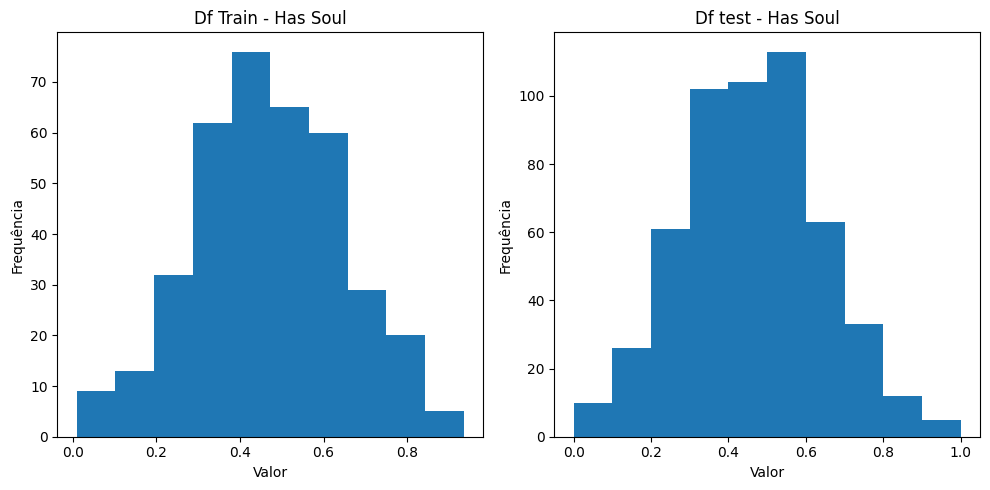

In [15]:
# Has Soul

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))


ax1.hist(df_train['has_soul'])
ax1.set_title('Df Train - Has Soul')
ax1.set_xlabel('Valor')
ax1.set_ylabel('Frequência')


ax2.hist(df_test['has_soul'])
ax2.set_title('Df test - Has Soul')
ax2.set_xlabel('Valor')
ax2.set_ylabel('Frequência')


plt.tight_layout()
plt.show()

In [16]:
df_train.describe()

,id,bone_length,rotting_flesh,hair_length,has_soul
count,371.000000,371.000000,371.000000,371.000000,371.000000
mean,443.676550,0.434160,0.506848,0.529114,0.471392
std,263.222489,0.132833,0.146358,0.169902,0.176129
min,0.000000,0.061032,0.095687,0.134600,0.009402
25%,205.500000,0.340006,0.414812,0.407428,0.348002
50%,458.000000,0.434891,0.501552,0.538642,0.466372
75%,678.500000,0.517223,0.603977,0.647244,0.600610
max,897.000000,0.817001,0.932466,1.000000,0.935721


In [17]:
df_test.describe()

,id,bone_length,rotting_flesh,hair_length,has_soul
count,529.000000,529.000000,529.000000,529.000000,529.000000
mean,453.584121,0.425474,0.503637,0.517288,0.464096
std,257.804948,0.136079,0.158552,0.171727,0.179659
min,3.000000,0.000000,0.000000,0.000000,0.000000
25%,239.000000,0.329383,0.393987,0.388189,0.338964
50%,445.000000,0.421989,0.510065,0.520220,0.461294
75%,670.000000,0.519024,0.605957,0.644824,0.584448
max,899.000000,1.000000,1.000000,0.999841,1.000000


In [18]:
len(df_test), len(df_train)

(529, 371)

In [19]:
df_test['color']

0      black
1      white
2      black
3      white
4      black
       ...  
524     blue
525    clear
526    white
527    clear
528    white
Name: color, Length: 529, dtype: object

## Definindo as labels

In [20]:
aux = df_train['type'].drop_duplicates().to_list()
labels_ant = aux

labels = {}
for index, label in enumerate(aux):
  labels[label] = len(aux)-1-index
labels

{'Ghoul': 2, 'Goblin': 1, 'Ghost': 0}

In [21]:
df_train_aux["label"] = df_train_aux["type"].apply(lambda x: labels[x])
df_train_aux

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type,label
0,0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul,2
1,1,0.575560,0.425868,0.531401,0.439899,green,Goblin,1
2,2,0.467875,0.354330,0.811616,0.791225,black,Ghoul,2
3,4,0.776652,0.508723,0.636766,0.884464,black,Ghoul,2
4,5,0.566117,0.875862,0.418594,0.636438,green,Ghost,0
...,...,...,...,...,...,...,...,...
366,886,0.458132,0.391760,0.660590,0.635689,blue,Goblin,1
367,889,0.331936,0.564836,0.539216,0.551471,green,Ghost,0
368,890,0.481640,0.501147,0.496446,0.544003,clear,Ghoul,2
369,896,0.294943,0.771286,0.583503,0.300618,clear,Ghost,0


## Preparando as features

In [22]:
label_encoder = LabelEncoder()
df_train_aux['num_color'] = label_encoder.fit_transform(df_train_aux['color'])
df_train_aux

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type,label,num_color
0,0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul,2,3
1,1,0.575560,0.425868,0.531401,0.439899,green,Goblin,1,4
2,2,0.467875,0.354330,0.811616,0.791225,black,Ghoul,2,0
3,4,0.776652,0.508723,0.636766,0.884464,black,Ghoul,2,0
4,5,0.566117,0.875862,0.418594,0.636438,green,Ghost,0,4
...,...,...,...,...,...,...,...,...,...
366,886,0.458132,0.391760,0.660590,0.635689,blue,Goblin,1,2
367,889,0.331936,0.564836,0.539216,0.551471,green,Ghost,0,4
368,890,0.481640,0.501147,0.496446,0.544003,clear,Ghoul,2,3
369,896,0.294943,0.771286,0.583503,0.300618,clear,Ghost,0,3


In [23]:
colors_dict = df_train_aux.drop_duplicates(['color', 'num_color']).reset_index()[['color', 'num_color']].to_dict()['color']
colors_dict_aux = {}

for i in colors_dict:
  colors_dict_aux[colors_dict[i]] = i
colors_dict_aux

{'clear': 0, 'green': 1, 'black': 2, 'white': 3, 'blue': 4, 'blood': 5}

In [24]:
df_test_aux["num_color"] = df_test_aux["color"].apply(lambda x: colors_dict_aux[x])
df_test_aux

,id,bone_length,rotting_flesh,hair_length,has_soul,color,num_color
0,3,0.471774,0.387937,0.706087,0.698537,black,2
1,6,0.427332,0.645024,0.565558,0.451462,white,3
2,9,0.549602,0.491931,0.660387,0.449809,black,2
3,10,0.638095,0.682867,0.471409,0.356924,white,3
4,13,0.361762,0.583997,0.377256,0.276364,black,2
...,...,...,...,...,...,...,...
524,893,0.377573,0.390158,0.696465,0.355373,blue,4
525,894,0.229161,0.601265,0.191282,0.475115,clear,0
526,895,0.510497,0.498347,0.708020,0.714154,white,3
527,898,0.331472,0.765835,0.338207,0.193431,clear,0


In [25]:
df_train_aux.columns

Index(['id', 'bone_length', 'rotting_flesh', 'hair_length', 'has_soul',
       'color', 'type', 'label', 'num_color'],
      dtype='object')

## Treino dos modelos e criação das métricas comparativas

In [26]:
d = DecisionTreeClassifier()
r = RandomForestClassifier()
kn = KNeighborsClassifier()

In [27]:
modeller=[d, r, kn]
isimler=["DecisionTreeClassifier", "RandomForestClassifier", "KNeighborsClassifier"]

accuracy, precision, recall, f1, mdl = [], [], [], [], []

In [28]:
for model in modeller:

  x_train, x_test, y_train, y_test = train_test_split(df_train_aux[['bone_length', 'rotting_flesh', 'hair_length', 'has_soul', 'num_color']],
                                                      df_train_aux["label"],
                                                      test_size=0.10,
                                                      random_state = 42)

  model=model.fit(x_train,y_train)
  tahmin=model.predict(np.array(x_test) if model==kn else x_test)
  mdl.append(model)
  accuracy.append(accuracy_score(y_test, tahmin))
  precision.append(precision_score(y_test, tahmin, average="micro"))
  recall.append(recall_score(y_test, tahmin, average="micro"))
  f1.append(f1_score(y_test, tahmin, average="micro"))

/home/melot/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [29]:
metrics=pd.DataFrame(columns=["Accuracy", "Precision", "Recall", "F1", "Model"], index=isimler)
metrics["Accuracy"] = accuracy
metrics["Precision"] = precision
metrics["Recall"] = recall
metrics["F1"] = f1
metrics["Model"]=mdl

metrics.sort_values("F1", ascending=False, inplace=True)

model=metrics.iloc[0,-1]
tahmin=model.predict(np.array(x_test) if model==kn else x_test)
print("classification Report:")
print(classification_report(y_test, tahmin))

metrics.drop("Model", axis=1)

classification Report:
              precision    recall  f1-score   support

           0       0.90      0.69      0.78        13
           1       0.67      0.71      0.69        14
           2       0.69      0.82      0.75        11

    accuracy                           0.74        38
   macro avg       0.75      0.74      0.74        38
weighted avg       0.75      0.74      0.74        38



,Accuracy,Precision,Recall,F1
RandomForestClassifier,0.736842,0.736842,0.736842,0.736842
KNeighborsClassifier,0.684211,0.684211,0.684211,0.684211
DecisionTreeClassifier,0.657895,0.657895,0.657895,0.657895


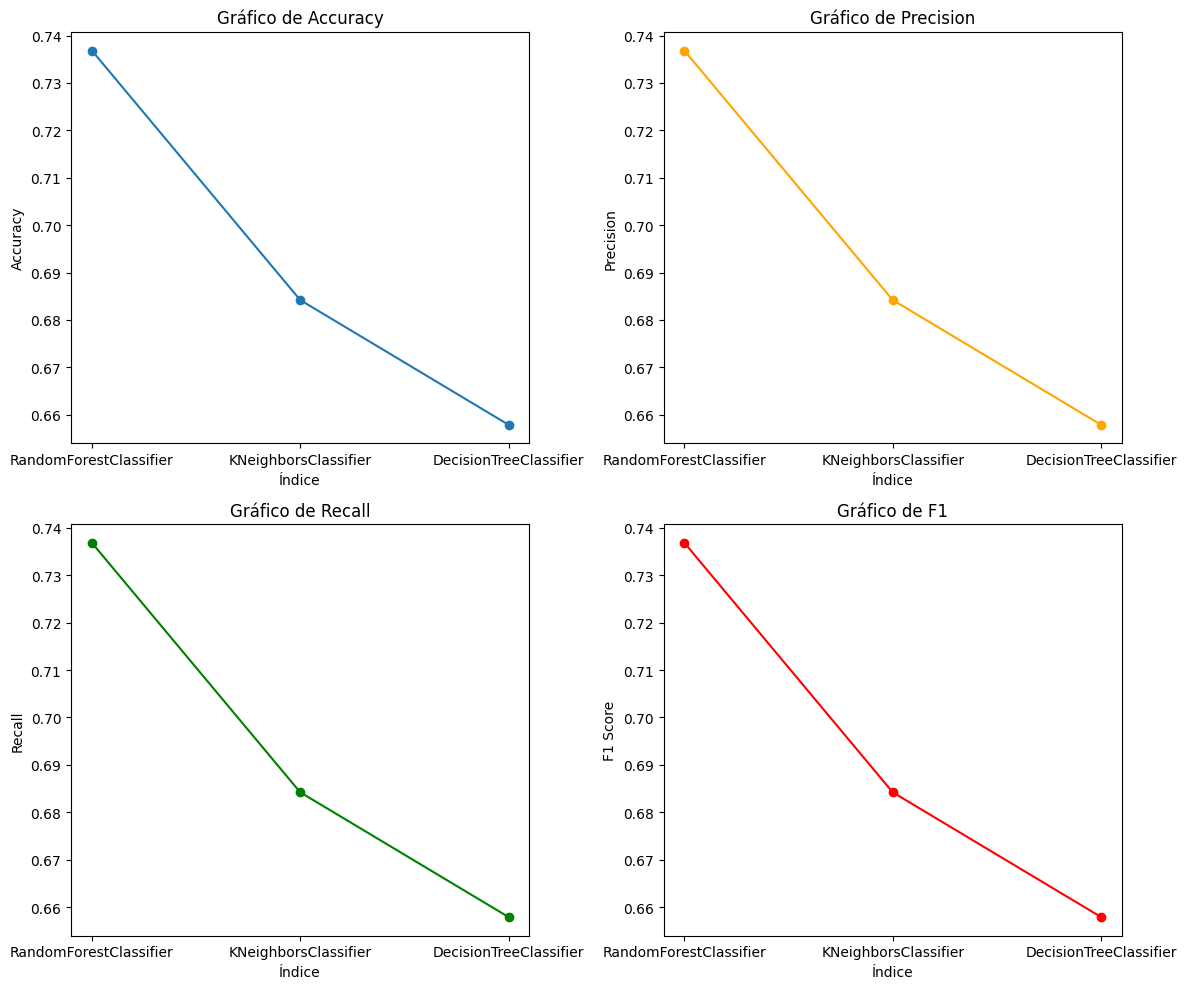

In [30]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# Primeiro gráfico de linha
ax1.plot(metrics['Accuracy'], marker='o')
ax1.set_title('Gráfico de Accuracy')
ax1.set_xlabel('Índice')
ax1.set_ylabel('Accuracy')

# Segundo gráfico de linha
ax2.plot(metrics['Precision'], marker='o', color='orange')
ax2.set_title('Gráfico de Precision')
ax2.set_xlabel('Índice')
ax2.set_ylabel('Precision')

# Terceiro gráfico de linha
ax3.plot(metrics['Recall'], marker='o', color='green')
ax3.set_title('Gráfico de Recall')
ax3.set_xlabel('Índice')
ax3.set_ylabel('Recall')

# Quarto gráfico de linha
ax4.plot(metrics['F1'], marker='o', color='red')
ax4.set_title('Gráfico de F1')
ax4.set_xlabel('Índice')
ax4.set_ylabel('F1 Score')

plt.tight_layout()
plt.show()

## Utilização do melhor modelo para predizer o dataset de teste

In [31]:
x_train, y_train = df_train_aux[['bone_length', 'rotting_flesh', 'hair_length', 'has_soul', 'num_color']], df_train_aux["label"]

In [32]:
rfc = RandomForestClassifier()
rfc_model = rfc.fit(x_train, y_train)

In [33]:
x = pd.get_dummies(df_test_aux[['bone_length', 'rotting_flesh', 'hair_length', 'has_soul', 'num_color']], drop_first=True)
x

,bone_length,rotting_flesh,hair_length,has_soul,num_color
0,0.471774,0.387937,0.706087,0.698537,2
1,0.427332,0.645024,0.565558,0.451462,3
2,0.549602,0.491931,0.660387,0.449809,2
3,0.638095,0.682867,0.471409,0.356924,3
4,0.361762,0.583997,0.377256,0.276364,2
...,...,...,...,...,...
524,0.377573,0.390158,0.696465,0.355373,4
525,0.229161,0.601265,0.191282,0.475115,0
526,0.510497,0.498347,0.708020,0.714154,3
527,0.331472,0.765835,0.338207,0.193431,0


In [34]:
pred = rfc_model.predict(x)
pred_monsters = []
for i in pred:
  pred_monsters.append(labels_ant[i])

In [35]:
df_result = df_test.copy()
df_result['monster_pred'] = pred_monsters
merged_df = pd.merge(df_result, df_ssub, on='id', how='inner')
merged_df = merged_df.rename(columns={"type": "monster"})
merged_df

,id,bone_length,rotting_flesh,hair_length,has_soul,color,monster_pred,monster
0,3,0.471774,0.387937,0.706087,0.698537,black,Ghost,Ghost
1,6,0.427332,0.645024,0.565558,0.451462,white,Goblin,Ghost
2,9,0.549602,0.491931,0.660387,0.449809,black,Ghost,Ghost
3,10,0.638095,0.682867,0.471409,0.356924,white,Ghoul,Ghost
4,13,0.361762,0.583997,0.377256,0.276364,black,Ghoul,Ghost
...,...,...,...,...,...,...,...,...
524,893,0.377573,0.390158,0.696465,0.355373,blue,Goblin,Ghost
525,894,0.229161,0.601265,0.191282,0.475115,clear,Ghoul,Ghost
526,895,0.510497,0.498347,0.708020,0.714154,white,Ghost,Ghost
527,898,0.331472,0.765835,0.338207,0.193431,clear,Ghoul,Ghost


In [36]:
identical_records = merged_df[merged_df['monster_pred'] == merged_df['monster']]
len(identical_records)

172

In [37]:
distinct_records = merged_df[merged_df['monster_pred'] != merged_df['monster']]
len(distinct_records)

357

## Conclusão

Neste projeto, abordamos o desafio "Ghouls, Goblins and Ghosts..." proposto pela Kaggle, cujo objetivo é identificar e classificar corretamente criaturas sobrenaturais utilizando algoritmos de machine learning. Utilizamos uma base de dados com 900 registros, sendo 371 registros alocados para treino e o restante para teste. Exploramos e pré-processamos os dados, transformando variáveis categóricas em numéricas e preparando os dados para o treinamento dos modelos.

Implementamos e avaliamos três algoritmos de machine learning: RandomForestClassifier, KNeighborsClassifier e DecisionTreeClassifier.

Abaixo estão os resultados obtidos para cada modelo em termos de acurácia, precisão, recall e F1-score:

|Modelo|Acurácia|Precisão|Recall|F1|
| ------------- | ------------- | ------------- | ------------- | ------------- |
|RandomForestClassifier|0.710526|0.710526|0.710526|0.710526|
|KNeighborsClassifier|0.684211|0.684211|0.684211|0.684211|
|DecisionTreeClassifier|0.631579|0.631579|0.631579|0.631579|

### **Algoritmos Utilizados**

**RandomForestClassifier:**

Descrição: É um algoritmo de ensemble que utiliza múltiplas árvores de decisão para realizar classificações. Cada árvore é treinada em um subconjunto diferente dos dados, e a decisão final é tomada com base na maioria das previsões das árvores.
Resultado: O modelo RandomForestClassifier apresentou a melhor performance entre os três algoritmos, com uma acurácia de 71.05%.

**KNeighborsClassifier:**

Descrição: Este algoritmo classifica os pontos de dados com base nos rótulos dos pontos de dados mais próximos no espaço de características. O número de vizinhos (k) é um hiperparâmetro que pode ser ajustado para otimizar a performance.
Resultado: O KNeighborsClassifier teve uma acurácia de 68.42%, mostrando um desempenho razoável na classificação das criaturas.

**DecisionTreeClassifier:**

Descrição: Utiliza uma estrutura de árvore para tomar decisões de classificação com base em uma série de perguntas sim/não sobre os atributos dos dados. Cada nó da árvore representa uma decisão baseada em um atributo, levando a uma classificação final.
Resultado: O modelo DecisionTreeClassifier teve a menor acurácia, com 63.16%, indicando que uma única árvore de decisão pode não ser suficiente para capturar a complexidade dos dados.

### **Conclusão Final**

Através da implementação e avaliação de diferentes algoritmos de machine learning, fomos capazes de construir modelos que identificam e classificam criaturas sobrenaturais com um nível razoável de precisão. O RandomForestClassifier se destacou como o modelo mais eficaz, sugerindo que métodos de ensemble podem ser mais robustos e fornecer melhores resultados em problemas de classificação complexos.

Este projeto forneceu uma experiência prática valiosa na aplicação de técnicas de machine learning para resolver problemas reais. A análise e o pré-processamento cuidadoso dos dados, juntamente com a seleção e avaliação de modelos apropriados, foram fundamentais para alcançar resultados satisfatórios.

Vamos agora utilizar este conhecimento para continuar aprimorando nossos modelos e explorar outras técnicas que possam melhorar ainda mais a precisão da classificação.